In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
#%%timeit

import random
from PIL import Image
 
 
class BarnsleyFern(object):
    def __init__(self, img_width, img_height, paint_color=(0, 150, 0),
                 bg_color=(255, 255, 255)):
        self.img_width, self.img_height = img_width, img_height
        self.paint_color = paint_color
        self.x, self.y = 0, 0
        self.age = 0
 
        self.fern = Image.new('RGB', (img_width, img_height), bg_color)
        self.pix = self.fern.load()
        self.pix[self.scale(0, 0)] = paint_color
 
    def scale(self, x, y):
        h = (x + 2.182)*(self.img_width - 1)/4.8378
        k = (9.9983 - y)*(self.img_height - 1)/9.9983
        return h, k
 
    def transform(self, x, y):
        rand = random.uniform(0, 100)
        if rand < 1:
            return 0, 0.16*y
        elif 1 <= rand < 86:
            return 0.85*x + 0.04*y, -0.04*x + 0.85*y + 1.6
        elif 86 <= rand < 93:
            return 0.2*x - 0.26*y, 0.23*x + 0.22*y + 1.6
        else:
            return -0.15*x + 0.28*y, 0.26*x + 0.24*y + 0.44
 
    def iterate(self, iterations):
        for _ in range(iterations):
            self.x, self.y = self.transform(self.x, self.y)
            self.pix[self.scale(self.x, self.y)] = self.paint_color
        self.age += iterations
 
fern = BarnsleyFern(500, 500)
fern.iterate(1000000)
fern.fern.show()
 

In [5]:
transforms = [m1,m2,m3,m4]

In [38]:
#%%timeit
import random
import numpy
from PIL import Image

class BarnsleyFern(object):
    
    
    def __init__(self, img_width, img_height, 
                 paint_colors=[(0, 150, 0), (150, 150, 0)],
                 bg_color=(255, 255, 255)):
        
        self.img_width, self.img_height = img_width, img_height
        self.paint_colors = paint_colors

        self.x, self.y = 0, 0
 
        self.fern = Image.new('RGB', (img_width, img_height), bg_color)
        self.pix = self.fern.load()
        self.pix[self.scale(self.x, self.y)] = paint_colors[0]
        
    def scale(self, x,y):
        h = (x + 2.182)*(self.img_width - 1)/4.8378
        k = (9.9983 - y)*(self.img_height - 1)/9.9983
        return h, k
        
    # just to be tidy with namespace
    def m1(self,x,y):
        return 0, 0.16*y
    
    def m2(self,x,y):
        return 0.85*x + 0.04*y, -0.04*x + 0.85*y + 1.6
    
    def m3(self,x,y):
        return 0.2*x - 0.26*y, 0.23*x + 0.22*y + 1.6
    
    def m4(self, x,y):
        return -0.15*x + 0.28*y, 0.26*x + 0.24*y + 0.44

    def iterate(self, iterations):
        
        # cache everything to save lookups in the loop
        # every . is a dictionnary lookup
        x, y = self.x, self.y
        img, scale, color  = self.pix, self.scale, self.paint_colors[0]
        transforms = [self.m1, self.m2, self.m3, self.m4]
        
        #avoid using cascading ifs by using relative weights
        for i, f in enumerate(random.choices(transforms, 
                                weights=[1,60,7,7], 
                                k=iterations)):
            x, y  = f(x,y)
            img[scale(x,y)] = color
            
 
fern = BarnsleyFern(500, 500)
fern.iterate(1000000)
fern.fern.show()

this is about 25% quicker probably from caching

In [62]:
%%timeit
import random
import numpy as np
from PIL import Image

class BarnsleyFern(object):
    
    
    def __init__(self, img_width, img_height, paint_color=(0, 150, 0),
                 bg_color=(255, 255, 255)):
        
        self.img_width, self.img_height = img_width, img_height
        self.paint_color = paint_color
        self.x, self.y = 0, 0
        self.v = np.array([self.x, self.y,1])
 
        self.fern = Image.new('RGB', (img_width, img_height), bg_color)
        self.pix = self.fern.load()
        
        
        #I got a sign wrong and it took an hour to find it!!!!
        self.generators = [ [0,0,0,0, 1.6,0],
              [ 0.85,  0.04, 0, -0.04,  0.85,  1.6],
              [  0.2, -0.26, 0,  0.23,  0.22,  1.6 ],
              [-0.15,  0.28, 0,  0.26,  0.24, 0.44 ]
             ]
        
        # these values shouldn't be hard coded
        mm = np.array([[1,0, 2.182], [0,-1,9.9983 ], [0,0,1]])
        mm[0] = mm[0]*(self.img_width - 1)/5
        mm[1] = mm[1]*(self.img_height - 1)/10
        self.scale = mm
        
        x,y,z = np.dot(self.scale, self.v)
        self.pix[x,y] = paint_color
        
    def scale_f(self, x,y):
        h = (x + 2.182)*(self.img_width - 1)/4.8378
        k = (9.9983 - y)*(self.img_height - 1)/9.9983
        return h, k
        
    
    def mk_transforms(self, shuffle=False):
        def coeffs2matrix(m):
             return np.vstack((np.array(m).reshape(2,3), 
                               np.array([0,0,1])))
                     
        matrices = [ coeffs2matrix(m)  for m in self.generators]
        
        if not shuffle: 
            return [ f.dot for f in matrices]
                      
        shuffles = [np.random.random((2,3))*0.01 for k in range(4)]
        shuffles[0] = np.zeros((2,3))
        
        for a,b in zip(matrices, shuffles):
            a[:2,:3] = a[:2,:3] + b
            
        return matrices


    def iterate(self, iterations):
        
        # cache everything to save lookups in the loop
        # remember every . is a dictionnary lookup
        v = self.v
        img, scale, color  = self.pix, self.scale.dot, self.paint_color
        
        transforms = self.mk_transforms()
        #avoid using cascading ifs by using relative weights
        for f in random.choices( transforms, 
                                weights=[0,80,10,10], 
                                k=iterations):
            
            #np.dot is matrix multiplication
            v = f(v)
            w = scale(v)
            img[w[0],w[1]] = color
            
 
fern = BarnsleyFern(500, 500)
fern.iterate(1000000)
fern.fern.show()

# this is slower I wonder what the overhead is 

2.21 s ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
np.random.random((2,3))

array([[0.33971811, 0.66154564, 0.27172619],
       [0.52796106, 0.00872534, 0.12033717]])

The attractor of the iterated function system given by the set of "fern functions"

$$m_2(x,y)	=	[0.85 0.04; -0.04 0.85][x; y]+[0.00; 1.60] 
(1)\\
m_3(x,y)	=	[-0.15 0.28; 0.26 0.24][x; y]+[0.00; 0.44] 
(2)\\
m_4(x,y)	=	[0.20 -0.26; 0.23 0.22][x; y]+[0.00; 1.60] 
(3)\\
m_(x,y)1	=	[0.00 0.00; 0.00 0.16][x; y]
(4)
$$
(Barnsley 1993, p. 86; Wagon 1991). 

These affine transformations are contractions. 

- the tip of the fern (which resembles the black spleenwort variety of fern) is the fixed point of f_1, 
- the tips of the lowest two branches are the images of the main tip under f_2 and f_3 (Wagon 1991).



In [ ]:
#%%timeit


def normalize(X, size=512):
    M, m = max(X), min(X)
    X = (size - 1)*(X - m )/(M - m)
    return X.astype(int)

    
generators = [ #[0.00, 0.00, 0.00, 0.16, 0.00, 0.00 ],
              [ 0.85,  0.04, 0, -0.04,  0.85,  1.6],
              [  0.2, -0.26, 0,  0.23,  0.22,  1.6 ],
              [-0.15,  0.28, 0,  0.26,  0.24, 0.44 ]
             ]


matrices = [ np.array(g).reshape(2,3) for g in generators ]
transforms = [ np.vstack([f,np.array([0,0,1])]).dot for f in matrices]


u = np.array([ [0,0, 1] ] ).reshape(-1,1)
v = []
for k  in range(4):
    u = transforms[1](u)
    v.append(u)
    
v = np.hstack(v)

for k in range(12):  
    v = np.hstack([f(v) for f in transforms ])
    
ss = 512

img = np.ones((ss, ss))
img[normalize( 1- v[1]) , normalize( v[0]) ] = 0.

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.set_aspect('equal')

ax.imshow(img);

In [13]:
v = np.zeros((3,2))
v[:,1] = u.reshape(-1,3)[0]
v[:,0] = [0,.1,1]

In [33]:
for M in matrices:
    
    a, b = M[:2, :2] - np.identity(2), M[:,2]
    print(np.linalg.solve(a,b))

[-2.65560166 -9.95850622]
[ 0.60836502 -1.87189237]
[-0.15376935 -0.63155267]


In [ ]:
(x + 2.182)*(self.img_width - 1)/4.8378
(9.9983 - y)*(self.img_height - 1)/9.9983

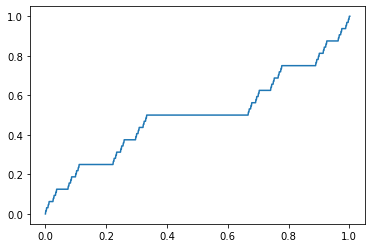

In [53]:
def mk_transforms(generators, 
                  depth=4, 
                  dim=2):
    
    elts = [np.identity(dim)]   
    for k in range(depth):
        elts.extend( [np.dot(M,G) 
                        for M in elts
                        for G in generators])
    return elts

motif = np.array([[0,0,1],[1,1,1], [2,1,1]]).T

#scaling
L = np.array( [[1/3, 0 ,0], [ 0, 1/2 ,0], [0, 0, 1]])
#scaling then translation by (2/3, 1/2)
R = np.copy(L)
R[:2,-1] = np.array([2/3, 1/2])

n = 6
transforms = mk_transforms([L,R], depth=n, dim=3)

pts = np.hstack( [np.dot(f, motif) 
                  for f in transforms[-2**n::]])
X,Y,Z = pts
plt.plot(X,Y);

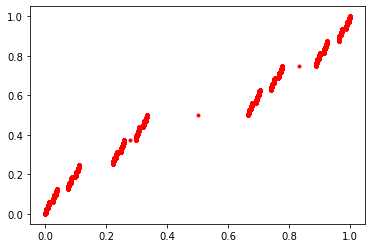

In [60]:
def mk_transforms(generators, 
                  depth=4, 
                  dim=2):
    
    elts = [np.identity(dim)]   
    for k in range(depth):
        elts.extend( [np.dot(M,G) 
                        for M in elts
                        for G in generators])
    return elts

motif = np.array([[0,0,1],[1,1,1], [2,1,1]]).T

#scaling
L = np.array( [[1/3, 0 ,0], [ 0, 1/2 ,0], [0, 0, 1]])
#scaling then translation by (2/3, 1/2)
R = np.copy(L)
R[:2,-1] = np.array([2/3, 1/2])

v = np.array([.5,.5,1])
pts = []
add = pts.append
for f in random.choices( [L,R], 
                         weights=[1,1], 
                         k=20000):
    add(v)
    v = np.dot(f,v)
    
pts = np.vstack(pts)
X,Y= pts[:,0], pts[:,1]
plt.plot(X,Y,'r.');

In [56]:
pts.shape

(20000, 3)